In [7]:
%matplotlib inline

import os
import glob
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from tqdm import tqdm,tqdm_notebook
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.set_option('display.max_columns', None)

import pickle
from functools import partial

**Logged historical login node info every hour with a script like**
```bash
#!/usr/bin/env bash
export PATH=/home/users/namin/.local/bin:$PATH
echo "date: $(date +%s)"
echo "------------"
echo "tinfo:"
time vim btest.py -c wq
echo "------------"
echo "lsinfo:"
time ls -l
echo "------------"
echo "topinfo:"
top -b -n 1 | head -n 25
echo "------------"
echo "\n\n\n"
```

In [2]:
def get_blocks(uaf):
    blocks = []
    with open("data/uaf{}.log".format(uaf),"r") as fhin:
        block = []
        for line in fhin:
            if line.startswith("date: "):
                if len(block):
                    blocks.append("".join(block))
                block = []
            block.append(line)
    return blocks

def parse_date(sblock):
    return int(sblock.split(":",1)[-1].strip())

def parse_tline(tline):
    mins, secs = tline.split()[-1].replace("s","").split("m")
    return 60.0*int(mins) + float(secs)

def parse_vim(sblock):
    real,user,sys = -1,-1,-1
    for line in sblock.splitlines():
        if line.startswith("real"): real = parse_tline(line)
        elif line.startswith("user"): user = parse_tline(line)
        elif line.startswith("sys"): sys = parse_tline(line)
    return {"real": real, "user": user, "sys": sys}

def parse_ls(sblock):
    real,user,sys = -1,-1,-1
    for line in sblock.splitlines():
        if line.startswith("real"): real = parse_tline(line)
        elif line.startswith("user"): user = parse_tline(line)
        elif line.startswith("sys"): sys = parse_tline(line)
    return {"real": real, "user": user, "sys": sys}

def parse_top(sblock, uaf=-1):
    cpu,mem_free,mem_used = -1,-1,-1
    load1, load5, load15 = -1, -1, -1
    if uaf in [1,7]:
        for line in sblock.splitlines():
            if line.startswith("%Cpu(s)"):
                cpu = float(line.split(":",1)[1].split()[0])
                wait = float(line.split(":",1)[1].split()[8])
                nice = float(line.split(":",1)[1].split()[4])
            elif line.startswith("KiB Mem"):
                mem_used = round(int(line.split("used",1)[0].split()[-1].replace("+",""))/1.e6,2)
                mem_free = round(int(line.split("free",1)[0].split()[-1].replace("+",""))/1.e6,2)
            if line.startswith("top - ") and "load average" in line:
                loads = map(float,line.split("load average:",1)[-1].split(","))
                load1, load5, load15 = loads
    else:
        for line in sblock.splitlines():
            if line.startswith("Cpu(s)"):
                cpu = float(line.split(":",1)[1].split("%")[0])
                wait = float(line.split(":",1)[1].split(",")[4].split("%")[0])
                nice = float(line.split(":",1)[1].split(",")[2].split("%")[0])
            elif line.startswith("Mem:"):
                mem_used = round(int(line.split("used",1)[0].split()[-1][:-1])/1.e6,2)
                mem_free = round(int(line.split("free",1)[0].split()[-1][:-1])/1.e6,2)
            if line.startswith("top - ") and "load average" in line:
                loads = map(float,line.split("load average:",1)[-1].split(","))
                load1, load5, load15 = loads
    toplines = sblock.split("\n\n")[-1].splitlines()[1:]
    procs = []
    for line in toplines:
        pid, user, _, _, _, _, _, _, proccpu, mem, _, cmd = \
                line.split(None,11)
        if user == "root":
            if "fuse" not in cmd: continue
        procs.append([user, float(proccpu), float(mem), cmd.strip()])
    return {
            "cpu": cpu, "mem_used": mem_used, "mem_free": mem_free,
            "procs": procs, "nice": nice, "wait": wait,
            "load1": load1,
            "load5": load5,
            "load15": load15,
            }

def parse_block(block, uaf=-1):
    sblocks = block.split("------------")
    if not (len(sblocks) == 5):
        return {}
    assert(len(sblocks) == 5)
    data = {}
    data["uaf"] = uaf
    data["date"] = parse_date(sblocks[0])
    data["vim"] = parse_vim(sblocks[1])
    data["ls"] = parse_ls(sblocks[2])
    data["top"] = parse_top(sblocks[3], uaf=uaf)
    return data


def get_df(remake=False):
    """
    """
    pkl_fname = "data/data.pkl.bz2"
    if os.path.exists(pkl_fname) and not remake:
        return pd.read_pickle(pkl_fname)
    data = []
    for uaf in [1,4,7,8,10]:
        pblocks = map(partial(parse_block,uaf=uaf), tqdm(get_blocks(uaf)))
        for x in pblocks:
            if "date" not in x: continue
            d = {}
            d["date"] = x["date"]
            d["ls_real"] = x["ls"]["real"]
            d["ls_sys"] = x["ls"]["sys"]
            d["ls_user"] = x["ls"]["user"]
            d["vim_real"] = x["vim"]["real"]
            d["top_users"] = [y[0] for y in x["top"]["procs"]]
            d["top_procs"] = [y[3] for y in x["top"]["procs"]]
            d["top_cpu"] = x["top"]["cpu"]
            d["top_nice"] = x["top"]["nice"]
            d["top_wait"] = x["top"]["wait"]
            d["top_mem_used"] = x["top"]["mem_used"]
            d["top_mem_free"] = x["top"]["mem_free"]
            d["top_load1"] = x["top"]["load1"]
            d["top_load5"] = x["top"]["load5"]
            d["top_load15"] = x["top"]["load15"]
            d["uaf"] = uaf
            data.append(d)
    df = pd.DataFrame(data)
    df["date"] = pd.to_datetime(df.date,unit='s')
    df.to_pickle("data/data.pkl.bz2")
    return df

In [3]:
df = get_df()

df["ls_iofrac"] = df["ls_real"]/(df["ls_sys"]+df["ls_user"]+df["ls_real"])
df["ls_io"] = df["ls_real"]-(df["ls_sys"]+df["ls_user"])

df["date"] = df.date.dt.round("H")

dfs = []
for uaf in [1,4,7,8,10]:
    dfc = df[df.uaf==uaf]
    dfc = dfc.drop(["uaf"],axis=1)
    dfc.columns = ["{}{}".format(c, "" if c in ["date"] else "_{}".format(uaf)) for c in dfc.columns]
    dfs.append(dfc)
dfc = dfs[0]
for df in dfs[1:]:
    dfc = dfc.merge(df,on="date",how="outer")
# dfc is the combined dataframe

100%|██████████| 7803/7803 [00:01<00:00, 7480.81it/s]


In [8]:
dfc.head()

,date,ls_real_1,ls_sys_1,ls_user_1,top_cpu_1,top_load1_1,top_load15_1,top_load5_1,top_mem_free_1,top_mem_used_1,top_nice_1,top_procs_1,top_users_1,top_wait_1,vim_real_1,ls_iofrac_1,ls_io_1,ls_real_4,ls_sys_4,ls_user_4,top_cpu_4,top_load1_4,top_load15_4,top_load5_4,top_mem_free_4,top_mem_used_4,top_nice_4,top_procs_4,top_users_4,top_wait_4,vim_real_4,ls_iofrac_4,ls_io_4,ls_real_7,ls_sys_7,ls_user_7,top_cpu_7,top_load1_7,top_load15_7,top_load5_7,top_mem_free_7,top_mem_used_7,top_nice_7,top_procs_7,top_users_7,top_wait_7,vim_real_7,ls_iofrac_7,ls_io_7,ls_real_8,ls_sys_8,ls_user_8,top_cpu_8,top_load1_8,top_load15_8,top_load5_8,top_mem_free_8,top_mem_used_8,top_nice_8,top_procs_8,top_users_8,top_wait_8,vim_real_8,ls_iofrac_8,ls_io_8,ls_real_10,ls_sys_10,ls_user_10,top_cpu_10,top_load1_10,top_load15_10,top_load5_10,top_mem_free_10,top_mem_used_10,top_nice_10,top_procs_10,top_users_10,top_wait_10,vim_real_10,ls_iofrac_10,ls_io_10
0,2018-06-26 21:00:00,0.016,0.012,0.004,4.3,2.26,1.85,1.79,25.37,90.34,0.0,"[python, python, top]","[namin, namin, namin]",0.0,2.159,0.500000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-06-26 22:00:00,0.015,0.014,0.000,5.2,2.97,2.36,2.58,25.25,90.32,0.0,"[python, python, python, top]","[namin, namin, namin, namin]",0.0,2.302,0.517241,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010,0.008,0.000,0.2,0.24,0.06,0.06,2.39,1.92,0.0,[top],[namin],0.0,2.428,0.555556,0.002,0.008,0.005,0.002,0.7,0.59,0.31,0.39,30.17,19.24,0.1,"[cvmfs2, top]","[cvmfs, namin]",0.6,2.439,0.533333,0.001,0.049,0.019,0.002,16.5,26.04,26.26,23.97,0.99,131.05,8.4,"[fuse_dfs, runBabyMaker, root.exe, runBabyMake...","[root, sicheng, siconglu, sicheng, sicheng, si...",12.1,5.064,0.700000,0.028
2,2018-06-26 23:00:00,0.015,0.015,0.000,3.3,1.28,1.58,1.50,24.99,90.45,0.0,"[python, python, top, python]","[namin, namin, namin, bhashemi]",0.0,2.275,0.500000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004,0.002,0.001,0.4,0.03,0.05,0.03,2.40,1.92,0.0,[top],[namin],0.0,2.419,0.571429,0.001,0.006,0.003,0.002,0.7,0.18,0.26,0.25,5.40,44.02,0.1,"[top, python]","[namin, bemarsh]",0.6,2.454,0.545455,0.001,0.035,0.025,0.009,15.6,5.90,9.65,8.50,69.48,62.57,6.3,"[combine, combine, python, combine, setroubles...","[dpgilber, dpgilber, dpgilber, dpgilber, setro...",9.5,2.398,0.507246,0.001
3,2018-06-27 00:00:00,0.016,0.011,0.004,3.4,1.77,1.47,1.39,24.84,90.44,0.0,"[python, python, top, python]","[namin, namin, namin, namin]",0.0,2.963,0.516129,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013,0.012,0.000,0.2,0.00,0.05,0.02,2.40,1.92,0.0,[top],[namin],0.2,2.739,0.520000,0.001,0.020,0.006,0.003,0.7,0.24,0.37,0.31,3.87,45.54,0.1,"[top, condor_c-gahp]","[namin, letts]",0.6,2.508,0.689655,0.011,0.003,0.002,0.000,12.5,28.60,25.56,27.19,1.53,130.52,7.4,"[python, python, python, python, python, pytho...","[siconglu, siconglu, siconglu, siconglu, sicon...",12.3,34.004,0.600000,0.001
4,2018-06-27 01:00:00,0.016,0.016,0.000,3.8,1.56,1.47,1.45,24.72,90.44,0.0,"[python, python, top, cvmfs2, python]","[namin, namin, namin, cvmfs, namin]",0.0,2.287,0.500000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016,0.007,0.008,0.2,0.01,0.10,0.09,2.39,1.93,0.0,[top],[namin],0.0,2.420,0.516129,0.001,0.018,0.017,0.000,0.7,0.14,0.20,0.17,8.20,41.21,0.1,"[top, cvmfs2, cvmfs2, tmux, cvmfs2]","[namin, cvmfs, cvmfs, gkole, cvmfs]",0.6,2.494,0.514286,0.001,0.026,0.020,0.005,10.4,0.04,10.33,1.51,5.40,126.65,8.2,"[setroubleshootd, top, cvmfs2, condor_shadow, ...","[setroubl, namin, cvmfs, sjmay, phchang]",13.4,2.574,0.509804,0.001


Text(0,0.5,'ls_real_7')

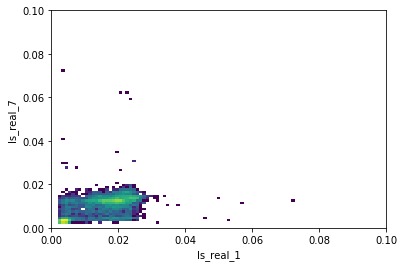

In [84]:
import corner
# df = dfc[["ls_real_10","ls_sys_10","ls_user_10","top_wait_10","ls_iofrac_10"]].dropna()
df = dfc.dropna()[[c for c in dfc.columns if (
#        ("_10" in c) and
       ("mem" not in c) and
       ("vim" not in c) and
       ("procs" not in c) and
       ("users" not in c)
       )]]
fig,ax = plt.subplots()
bins = [
#     np.linspace(0,1.0,100),
#     np.linspace(0,1.0,100),
    np.linspace(0,0.1,100),
    np.linspace(0,0.1,100),
#     np.linspace(0,0.2,100),
#     np.linspace(0,10,50),
#     np.linspace(0,10,50),
#     np.linspace(0,1.0,100),
]
# kx,ky = "ls_iofrac_10","top_cpu_10"
# kx,ky = "ls_iofrac_10","ls_iofrac_4"
# kx,ky = "ls_real_10","ls_real_4"
kx,ky = "ls_real_1","ls_real_7"
xs,ys = df[kx],df[ky]
ax.hist2d(xs,ys,bins=bins,norm=LogNorm());
ax.set_xlabel(kx)
ax.set_ylabel(ky)
# corner.corner(df,smooth1d=1)

In [6]:
from scipy.signal import savgol_filter
def smooth(x,window=11,npoly=1):
    return savgol_filter(x,window,npoly)



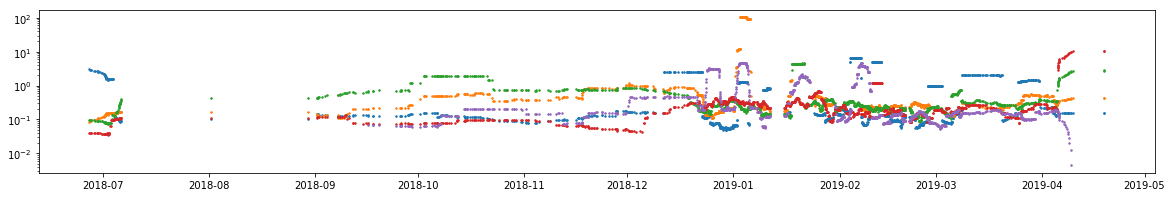

In [86]:
# df = dfc[(dfc.top_wait_10 > 3) & (dfc.top_wait_4 > 3)]
df = dfc[(dfc.ls_real_1 > 0.015) & (dfc.ls_real_7 > 0.013)]

fig,ax = plt.subplots(figsize=(20,3))
params=dict(ms=1.5)
# ax.plot_date(dfc.date,dfc.top_cpu_10,**params)
# ax.plot_date(dfc.date,dfc.top_wait_10,**params)
ax.plot_date(df.date,smooth(df.ls_io_10*100,51,1),**params)
ax.plot_date(df.date,smooth(df.ls_io_8*100,51,1),**params)
ax.plot_date(df.date,smooth(df.ls_io_7*100,51,1),**params)
ax.plot_date(df.date,smooth(df.ls_io_1*100,51,1),**params)
ax.plot_date(df.date,smooth(df.ls_io_4*100,51,1),**params)
ax.set_yscale("log")

In [88]:
df[["top_users_1","top_users_7","top_procs_1","top_procs_7"]]

,top_users_1,top_users_7,top_procs_1,top_procs_7
4,"[namin, namin, namin, cvmfs, namin]",[namin],"[python, python, top, cvmfs2, python]",[top]
9,"[namin, namin, namin, bhashemi]",[namin],"[python, python, top, python]",[top]
14,"[namin, namin, namin, bhashemi]",[namin],"[python, python, top, python]",[top]
17,"[namin, namin, bhashemi]",[namin],"[python, top, python]",[top]
38,"[namin, namin, namin, namin, bhashemi]",[namin],"[python, top, python, python, python]",[top]
40,"[namin, namin, namin, namin, bhashemi]",[namin],"[python, python, python, top, python]",[top]
57,"[namin, namin, namin]",[],"[python, top, python]",[]
62,"[namin, namin, namin]",[namin],"[python, top, python]",[top]
66,"[namin, namin, namin, bhashemi]",[namin],"[python, top, python, python]",[top]
67,"[namin, telegraf, namin, namin, bhashemi]",[namin],"[top, telegraf, python, python, python]",[top]
